In [1]:
#Data manipulation
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from functools import partial

import numpy as np

#Visualization & Graphic EDA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plt.style.use('ggplot')

#Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler,MaxAbsScaler, Imputer
from sklearn.model_selection import train_test_split

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import learning_curve, ShuffleSplit

#Another model
import xgboost as xgb

#Optimization
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


#Assessment
from sklearn.metrics import accuracy_score, classification_report, roc_curve


/home/grzeszo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# About data


Census data (age, education, country etc.), the goal is to predict whether a person makes over 50K $ a year. Raw dataset and its description can be found at UCI Machine Learning Repository (link below).

https://archive.ics.uci.edu/ml/datasets/adult



In [2]:
#Let's load it
data = pd.read_hdf('../train.adult.h5')

In [3]:
#what we have here...
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int8
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education-Num     32561 non-null int64
Martial Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null bool
Capital Gain      32561 non-null int16
Capital Loss      32561 non-null int16
Hours per week    32561 non-null int8
Country           31978 non-null object
Target            32561 non-null object
dtypes: bool(1), int16(2), int64(2), int8(2), object(8)
memory usage: 2.9+ MB


In [4]:
#more precisely about missing data
data.isnull().any()

Age               False
Workclass          True
fnlwgt            False
Education         False
Education-Num     False
Martial Status    False
Occupation         True
Relationship      False
Race              False
Sex               False
Capital Gain      False
Capital Loss      False
Hours per week    False
Country            True
Target            False
dtype: bool

In [5]:
#some descripitve stats - helpful for numeric data, for non-numeric we should try something else
data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,423.516600,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,3363.342471,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,-31441.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,27828.000000,4356.000000,99.000000


In [6]:
#how many values
data.apply(lambda x: x.nunique())

Age                  73
Workclass             8
fnlwgt            21648
Education            16
Education-Num        16
Martial Status        7
Occupation           14
Relationship          6
Race                  5
Sex                   2
Capital Gain        119
Capital Loss         92
Hours per week       94
Country              41
Target                2
dtype: int64

In [7]:
#what values?
data.select_dtypes(['object','bool']).apply(lambda x: x.value_counts()).T.stack()
#data.select_dtypes(['object','bool']).mode()

Workclass       Federal-gov                     960.0
                Local-gov                      2093.0
                Never-worked                      7.0
                Private                       22696.0
                Self-emp-inc                   1116.0
                Self-emp-not-inc               2541.0
                State-gov                      1298.0
                Without-pay                      14.0
Education       10th                            933.0
                11th                           1175.0
                12th                            433.0
                1st-4th                         168.0
                5th-6th                         333.0
                7th-8th                         646.0
                9th                             514.0
                Assoc-acdm                     1067.0
                Assoc-voc                      1382.0
                Bachelors                      5355.0
                Doctorate   

Some features are 'dominated' by certain values (e.g. country - almost 90% of observations are from US), some values are extremely rare (only 7 people of over 30 000 in dataset never worked. We should keep that in mind for later feature engineering

In [8]:
#transform non-numeric data to numeric form 
cat_feats = data.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    data['{0}_cat'.format(cat_feat)] = pd.factorize(data[cat_feat] )[0]

In [9]:
#on the right
data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Workclass_cat,Education_cat,Martial Status_cat,Occupation_cat,Relationship_cat,Race_cat,Country_cat,Target_cat
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,True,2174,0,40,United-States,<=50K,0,0,0,0,0,0,0,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,True,0,0,13,United-States,<=50K,1,0,1,1,1,0,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,True,0,0,40,United-States,<=50K,2,1,2,2,0,0,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,True,0,0,40,United-States,<=50K,2,2,1,2,1,1,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,False,0,0,40,Cuba,<=50K,2,0,1,3,2,1,1,0


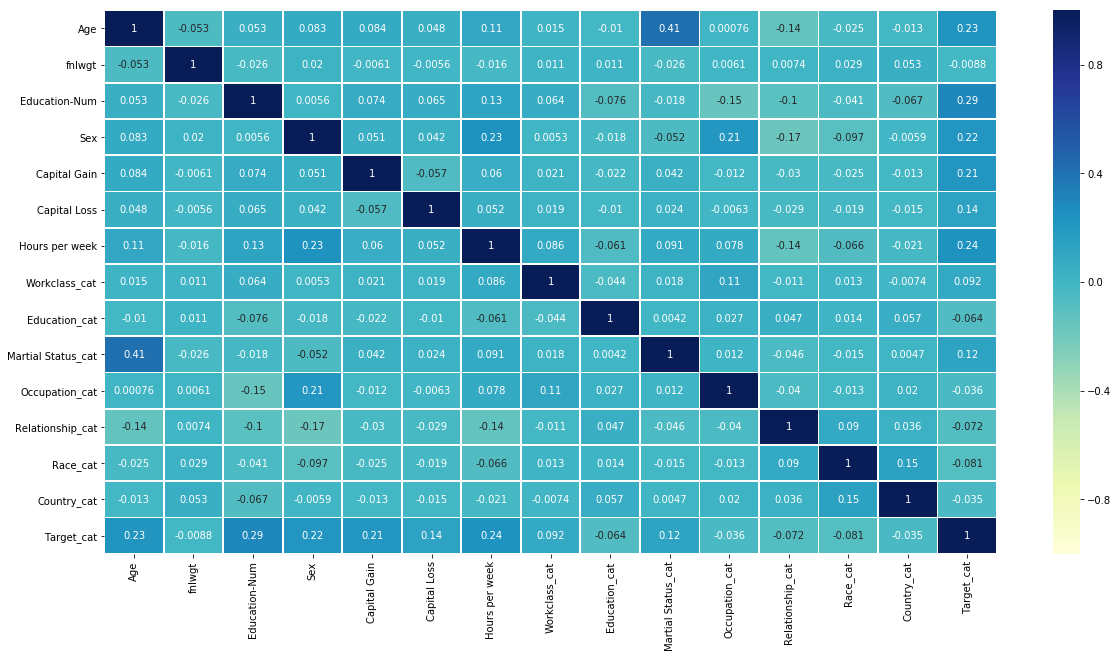

In [10]:
#now we can check correlations for all features

plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(data.corr(method='kendall'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

### Correlation. So what?

We should consieder two things - correlations between features (some of highly correlated features can be later dropped) and between each feature and target variable (features highly correalted with target variable usually should be included in final model). Also, this is good moment for sanity check (if we spot really counter-intuitve or nonsensical correlation, probably we should check our data) and to find some ideas for feature engineering.

#### feature x feature

It seems that most of observed correlation coefficients are really low (so most of our features are linearly independent). Two pairs are worth noting - Maritial status X Age (0.41; probably the older one is, the greater chance that he/she is married, divorced etc.) and sex X occupation (0.21; maybe there is more physical workers among men?). Generally, as we haven't spotted any stron correlations we shouldn't worry to much (at least now).

#### feature x target variable

Again, most of correlations are relatively weak. The most robust ones are age (older people are usually more experienced and tend to earn more), education in years (more educated usually earn more), sex (gender wage gap), capital gain and loss (rather self-explainable). It's to early to be absolutely sure, but probably these feautures should be included in our model.



# Some feature engineering

In [11]:
#probably one will ear less on retirement
data['Retirement'] = (data.Age >= 65)

#
data['White_husband'] = ((data.Relationship == 'Husband') & (data.Race == 'White'))
data['Black_husband'] = ((data.Relationship == 'Husband') & (data.Race == 'Black'))

#Race x sex
data['White_male'] = ((data.Race == 'White') & (data.Sex == False))
data['Black_male'] = ((data.Race =="Black") & (data.Sex == False))

data['White_female'] = ((data.Race == 'White') & (data.Sex == True))
data['Black_female'] = ((data.Race == "Black") & (data.Sex == True))

#well-educated tend to earn more
data['Higher_education'] = (data.Education.isin(['Bachelors','Masters','Doctorate']))



#you'll earn more in US than e.g. Guatemala
data['Rich_country'] = (data.Country.isin(['United-States', 'Germany', 'Japan', 'France', 'England', 'Scotland', 'Canada','Italy','Holand-Netherlands']))

#managers usually earn much more than the rest
data['Is_manager?'] = ((data.Occupation == 'Exec-managerial'))

# Threshold for many countries and also mean value 9in this case)
data['After_hours'] = ((data['Hours per week']) > 40)

#family to feed
data['Spouse'] = ((data.Relationship.isin(['Husband','Wife'])))

#
data['capital_gain_below_zero'] = data['Capital Gain'] < 0

#works for...
data['works_for_gov'] = (data.Workclass.isin(['Local-gov', 'State-gov' ,'Federal-gov']))
data['works_in_priv_sec'] = (data.Workclass == 'Private')

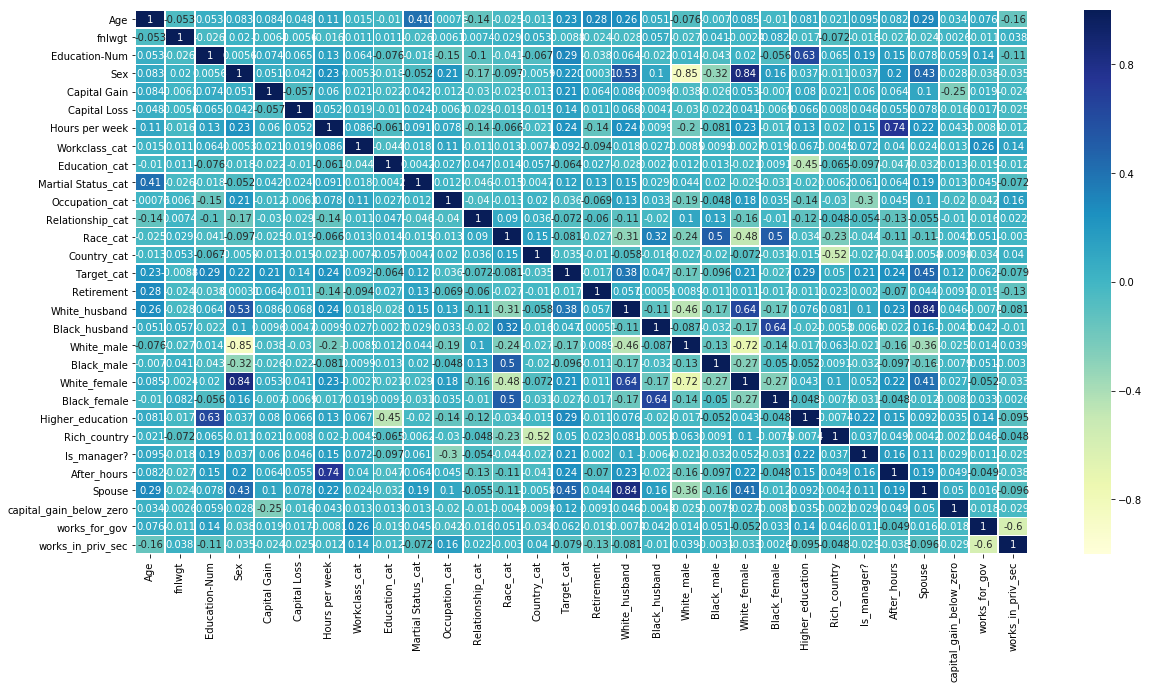

In [12]:
#correlation once again - now we include new features

plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(data.corr(method='kendall'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

Now we see some strong correlations between original features and new ones derived from them (e.g. sex and interaction race_sex). Probably some features can be dropped from model

# Buliding our model

In [13]:
#features for our model
feats = data.select_dtypes(include=['int8','int16','int64', 'bool']).columns.values
feats

array(['Age', 'fnlwgt', 'Education-Num', 'Sex', 'Capital Gain',
       'Capital Loss', 'Hours per week', 'Workclass_cat', 'Education_cat',
       'Martial Status_cat', 'Occupation_cat', 'Relationship_cat',
       'Race_cat', 'Country_cat', 'Target_cat', 'Retirement',
       'White_husband', 'Black_husband', 'White_male', 'Black_male',
       'White_female', 'Black_female', 'Higher_education', 'Rich_country',
       'Is_manager?', 'After_hours', 'Spouse', 'capital_gain_below_zero',
       'works_for_gov', 'works_in_priv_sec'], dtype=object)

In [14]:
#we'll be predicting this
feats = feats[feats!=['Target_cat']]
feats

array(['Age', 'fnlwgt', 'Education-Num', 'Sex', 'Capital Gain',
       'Capital Loss', 'Hours per week', 'Workclass_cat', 'Education_cat',
       'Martial Status_cat', 'Occupation_cat', 'Relationship_cat',
       'Race_cat', 'Country_cat', 'Retirement', 'White_husband',
       'Black_husband', 'White_male', 'Black_male', 'White_female',
       'Black_female', 'Higher_education', 'Rich_country', 'Is_manager?',
       'After_hours', 'Spouse', 'capital_gain_below_zero', 'works_for_gov',
       'works_in_priv_sec'], dtype=object)

In [15]:
X = data[feats]
y = data['Target_cat']

In [16]:
def train_and_predict(model, X, y, test_size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    
    #print(classification_report(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

In [17]:
# Pipeline

In [18]:
#we can change value in this cell and try different models
model = DecisionTreeClassifier(max_depth=10, random_state=123)

In [19]:
pipe = Pipeline([('imputer',Imputer(strategy='most_frequent')),
                 #('scaler', MaxAbsScaler()),
                 ('selector', SelectKBest(f_classif,k='all')),
                 ('CF', model)
                ])

In [20]:
train_and_predict(pipe, X, y, test_size=0.3)

0.84839799365339341

In [21]:
#Need more data?

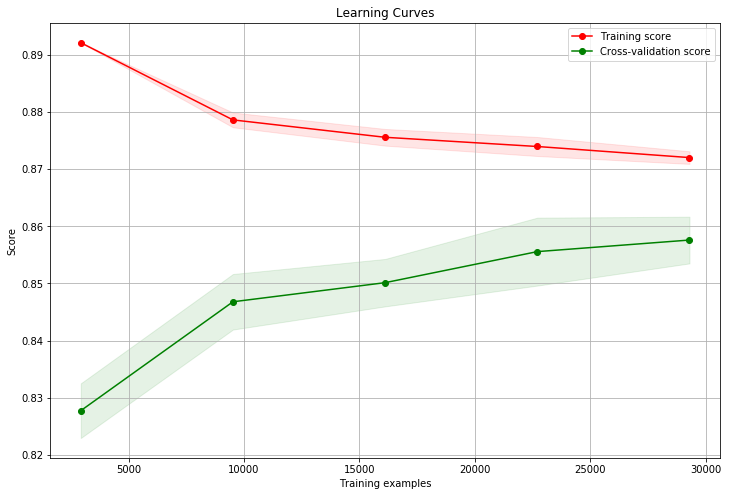

In [22]:
def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


plt = plot_learning_curve(model, "Learning Curves", X, y, cv=10, n_jobs=4)
plt.show()

Even relatively simple model in this case gives promising results, although it can definitely benefit from more samples. 

# Advanced models

In [23]:
#same as above, but this time we can try something more robust and computionally demanding
adv_model = RandomForestClassifier(n_estimators=80, max_depth=20, min_samples_split=2, min_samples_leaf=5, random_state=123)

In [24]:
adv_pipe = Pipeline([('imputer',Imputer(strategy='most_frequent')),
                     #('scaler', MaxAbsScaler()),
                     ('selector', SelectKBest(f_classif,k='all')),
                     ('CF', adv_model)
                    ])

In [25]:
train_and_predict(adv_pipe, X, y, test_size=0.33)

0.86201248848397993

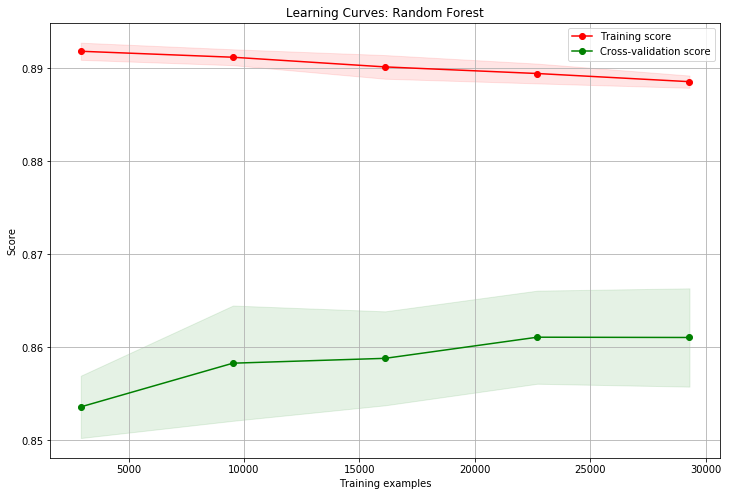

In [26]:

plt = plot_learning_curve(adv_model, "Learning Curves: Random Forest", X, y, cv=10, n_jobs=4)
plt.show()

# Feature importance

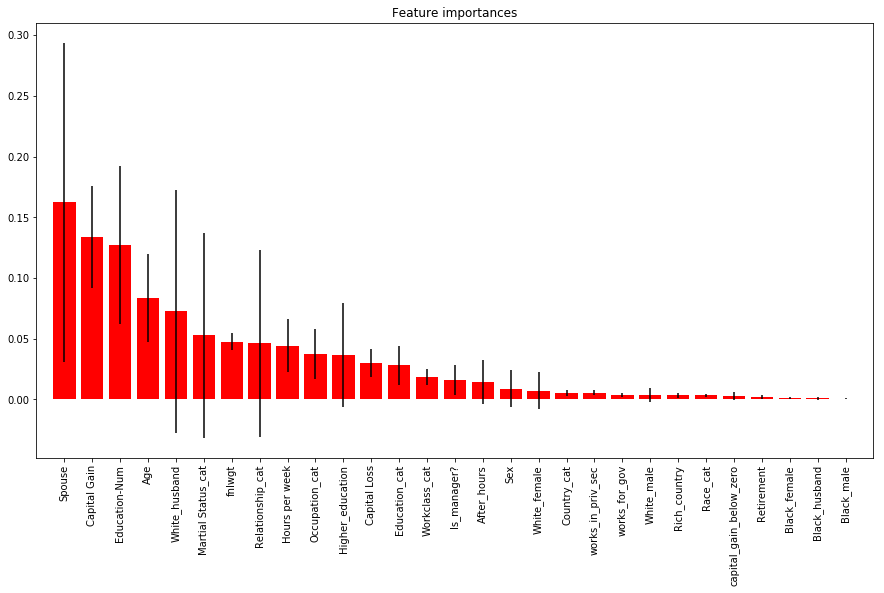

In [27]:
importances = np.array(adv_pipe.steps[2][1].feature_importances_)

std = np.std([tree.feature_importances_ for tree in adv_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest

plt.figure(figsize=[15,8])
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

Looks like we can drop some less important features (e.g. sex and and these on the right side of plot) and keep 15-17 most important. We can update it in pipeline

In [28]:
various_k = list(range(1,(len(feats)+1))) #basically list with all sensible number of features (from 1 to 26)

scores = []
for k in various_k:
    
    k_pipe = Pipeline([('selector', SelectKBest(f_classif,k=k)),
                         ('CF', adv_model)
                        ])
    score = train_and_predict(k_pipe, X, y, test_size=0.33)
    scores.append(score)
    #print(k,score)

In [29]:
#scores

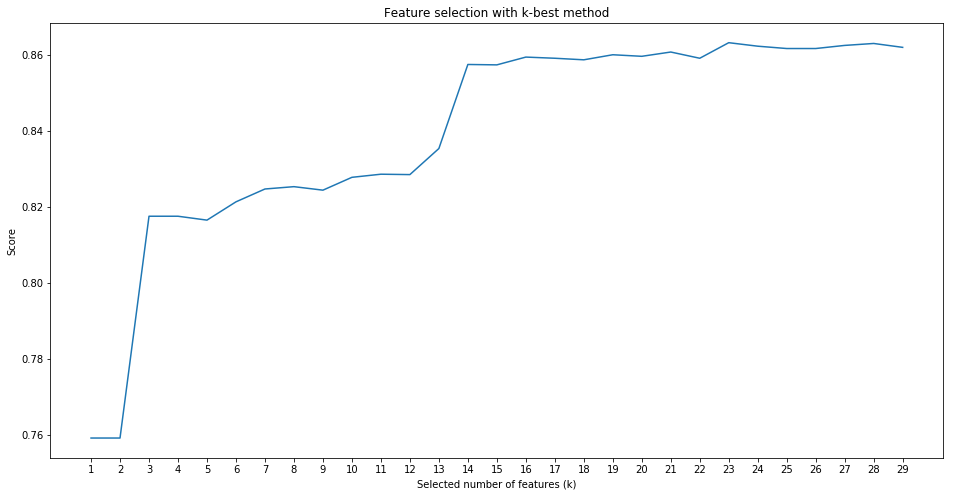

In [30]:
plt.figure(figsize=[16,8])
plt.plot(various_k,scores)
plt.xlabel('Selected number of features (k)')
plt.ylabel('Score')
plt.xticks(various_k)
plt.title('Feature selection with k-best method')
plt.show()


Apparently threshold k=15 seems crucial. Score still can be slightly improved, though. Now we can easily use our first pipeline with simply chanigng k='all' to interesting value (e.g. 14 or 25)

In [31]:
#scores[22] #careful with indices

# Gradient Boosting

In [32]:
gb_model = xgb.XGBClassifier(max_depth=4)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
gb_pipe = Pipeline([('imputer',Imputer(strategy='most_frequent')),
                     #('scaler', MaxAbsScaler()),
                     ('selector', SelectKBest(f_classif,k='all')),
                     ('CF', gb_model)
                    ])

In [35]:
train_and_predict(gb_pipe, X, y, test_size=0.33)

0.8694851059473846

In [36]:
#plt = plot_learning_curve(gb_model, "Learning Curves: XGBoost", X, y, cv=1, n_jobs=4)
#plt.show()

# Using hyperopt to find better params

In [37]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100
    }
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    
    print("SCORE: {0}".format(score))
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 3, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.3),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=40,
            trials=trials)

print("The best params: ", best_params)

SCORE: 0.8688709182106664
SCORE: 0.8681543658511618
SCORE: 0.8699969290613164
SCORE: 0.8640597809397073
SCORE: 0.8695874705701709
SCORE: 0.8697921998157436
SCORE: 0.86764254273723
SCORE: 0.8601699252738254
SCORE: 0.8700992936841028
SCORE: 0.8611935715016891
SCORE: 0.8664141672637936
SCORE: 0.8590439144231754
SCORE: 0.8615006653700481
SCORE: 0.8688709182106664
SCORE: 0.8655952502815027
SCORE: 0.8642645101852799
SCORE: 0.8617053946156208
SCORE: 0.8607841130105436
SCORE: 0.8598628314054663
SCORE: 0.8626266762206981
SCORE: 0.8610912068789026
SCORE: 0.8610912068789026
SCORE: 0.8575084450813799
SCORE: 0.8573037158358071
SCORE: 0.8568942573446617
SCORE: 0.8564847988535162
SCORE: 0.8617053946156208
SCORE: 0.8593510082915344
SCORE: 0.8624219469751254
SCORE: 0.8627290408434845
SCORE: 0.8639574163169209
SCORE: 0.8674378134916573
SCORE: 0.8674378134916573
SCORE: 0.8650834271675709
SCORE: 0.8651857917903573
SCORE: 0.8655952502815027
SCORE: 0.8700992936841028
SCORE: 0.8628314054662709
SCORE: 0.86231

Hmmm... We can clearly see some improvement, altohugh it is kinda *subtle*. In general all three classifiers (or ensembles) give relatively similar results



## Why is that important?

Ok, we can predict with to some extent if someone will earn over 50k $ annually. What we can do with such information? 

1. Maybe we are selling some goods and we want to identify if someone is sufficiently rich to buy them from us?
2. Or we are politicians with robust social programme and we are trying to indentify our potential voters(if someone is not that wealthy, probably will be more eager to vote for left wing politicians)?

